In [ ]:
# !git clone https://github.com/KiLJ4EdeN/COVID_WEB
!git clone https://github.com/UCSD-AI4H/COVID-CT
# !cp COVID-CT/Images-processed/{CT_COVID.zip,CT_NonCOVID.zip} COVID_WEB
# !rm -rf COVID-CT
%cd /content/COVID-CT
!unzip /content/COVID-CT/Images-processed/CT_COVID.zip
!unzip /content/COVID-CT/Images-processed/CT_NonCOVID.zip

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!mkdir ~/.kaggle
! cp /content/drive/MyDrive/kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download plameneduardo/sarscov2-ctscan-dataset/

 94% 216M/230M [00:02<00:00, 80.9MB/s]
100% 230M/230M [00:02<00:00, 113MB/s] 


In [ ]:
!unzip /content/COVID-CT/sarscov2-ctscan-dataset.zip

unzip:  cannot find or open /content/COVID-CT/sarscov2-ctscan-dataset.zip, /content/COVID-CT/sarscov2-ctscan-dataset.zip.zip or /content/COVID-CT/sarscov2-ctscan-dataset.zip.ZIP.


In [ ]:
!cp -r /content/drive/MyDrive/ct_loader.py /content/COVID-CT

In [ ]:
!cp -r /content/COVID-CT/COVID/*.png /content/COVID-CT/CT_COVID
!cp -r /content/COVID-CT/non-COVID/*.png /content/COVID-CT/CT_NonCOVID

cp: cannot stat '/content/COVID-CT/COVID/*.png': No such file or directory
cp: cannot stat '/content/COVID-CT/non-COVID/*.png': No such file or directory


In [ ]:
#Creating train .txt files

import os

a= '\n'.join(f for f in os.listdir('/content/COVID-CT/CT_NonCOVID'))
with open('/content/COVID-CT/Data-split/NonCOVID/trainCT_NonCOVID2.txt', 'w') as outfile:
     outfile.write(a)  

a= '\n'.join(f for f in os.listdir('/content/COVID-CT/CT_COVID'))
with open('/content/COVID-CT/Data-split/COVID/trainCT_COVID2.txt', 'w') as outfile:
     outfile.write(a)  


#Creating test .txt files
a=open('/content/COVID-CT/Data-split/NonCOVID/testCT_NonCOVID.txt').read()
b= '\n'.join(f for f in os.listdir('/content/COVID-CT/CT_NonCOVID')[:150])
with open('/content/COVID-CT/Data-split/NonCOVID/testCT_NonCOVID2.txt', 'w') as outfile:
     outfile.write('\n'.join([a,b]))  


a=open('/content/COVID-CT/Data-split/COVID/testCT_COVID.txt').read()[:-1]
b= '\n'.join(f for f in os.listdir('/content/COVID-CT/CT_COVID')[:150])
with open('/content/COVID-CT/Data-split/COVID/testCT_COVID2.txt', 'w') as outfile:
     outfile.write('\n'.join([a,b]))

In [ ]:
%cd /content/COVID-CT

/content/COVID-CT


In [ ]:
import os
print(len(os.listdir('/content/COVID-CT/CT_COVID')))

1601


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import numpy as np
from tqdm import tqdm


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=2, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1)
        self.fc1 = nn.Linear(100352, 16)
        self.fc2 = nn.Linear(16, 2)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = self.conv3(x)
        x = F.relu(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        output = F.log_softmax(x, dim=1)
        return output

import torch
from torch import nn
from torchvision import models
import torch.nn.functional as F
import os, math

torch.autograd.set_detect_anomaly(True)

class ResNet(nn.Module):
    def __init__(self, layers=18, num_class=2, pretrained=True):
        super(ResNet, self).__init__()
        if layers == 18:
            self.resnet = models.resnet18(pretrained=pretrained)
        elif layers == 34:
            self.resnet = models.resnet34(pretrained=pretrained)
        elif layers == 50:
            self.resnet = models.resnet50(pretrained=pretrained)
        elif layers == 101:
            self.resnet = models.resnet101(pretrained=pretrained)
        elif layers == 152:
            self.resnet = models.resnet152(pretrained=pretrained)
        else:
            raise ValueError('layers should be 18, 34, 50, 101.')
        self.num_class = num_class
        if layers in [18, 34]:
            self.fc = nn.Linear(512, num_class)
        if layers in [50, 101, 152]:
            self.fc = nn.Linear(512 * 4, num_class)

    def conv_base(self, x):
        x = self.resnet.conv1(x)
        x = self.resnet.bn1(x)
        x = self.resnet.relu(x)
        x = self.resnet.maxpool(x)
        layer1 = self.resnet.layer1(x)
        layer2 = self.resnet.layer2(layer1)
        layer3 = self.resnet.layer3(layer2)
        layer4 = self.resnet.layer4(layer3)
        return layer1, layer2, layer3, layer4

    def forward(self, x):
        layer1, layer2, layer3, layer4 = self.conv_base(x)
        x = self.resnet.avgpool(layer4)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x


def client_update(global_model, optimizer, train_loader,client_number ,epoch=100,patience_epoch=50):
    global_model.train()
    loss_hist=[]
    print(f'************* Started training Client number: {client_number} ***************')

    for e in range(epoch):
        loss_hist=[]

        print(f'Epoch:{e}')
        for batch_idx, batch in enumerate(train_loader):

            # print(f'Iteration {batch_idx}/{len(train_loader)}')

            data, target = batch['img'].cuda(), batch['label'].cuda()

            optimizer.zero_grad()
            output = global_model(data)
            # print(target)
            # print(output)
            # print(target.size())
            # print(output.size())

            # pred = output.argmax(dim=1, keepdim=False)  # get the index of the max log-probability
            # print(pred)
            loss=torch.nn.CrossEntropyLoss()(output, target)
            # loss = torch.clamp(loss, min=-10, max=1000)
            # loss = F.nll_loss(output, target)
            # target.view(-1,1,1,1)
            # output.view(-1,1,1,1)
            # print(output[:,1])
            # print(target.size())

            # loss= torch.nn.BCELoss()(output, target)
            loss.backward()
            # torch.nn.utils.clip_grad_value_(model.parameters(), clip_value=200)
            loss_hist.append(loss)
            # print(loss)
            optimizer.step()
        # val_loss, val_acc = test_eval(global_model,val_loader)
        print('Training loss %0.3g |' % ( sum(loss_hist)/len(loss_hist)))
        # print('val loss %0.3g | val acc: %0.3f' % ( val_loss, val_acc))
        # loss_hist.append(val_loss)
        # if (e>patience_epoch and has_loss_spike(loss_hist,0.4)):
        #     print('Jump in val loss.... exiting training this client....')
        #     break;
    return loss.item()



def has_loss_spike(loss_hist,percent=0.4):
    if (len(loss_hist)>2):
        return (    (loss_hist[-1]-loss_hist[-2])  /loss_hist[-2] > percent)

    else:
        return False


def server_aggregate(global_model, client_models):
    global_dict = global_model.state_dict()
    for k in global_dict.keys():
        global_dict[k] = torch.stack([client_models[i].state_dict()[k] for i in range(len(client_models))], 0).float().mean(0)
    global_model.load_state_dict(global_dict)
    for model in client_models:
        model.load_state_dict(global_model.state_dict())


def perf_measure(y_actual, y_pred):
    TP = 0
    FP = 0
    TN = 0
    FN = 0

    for i in range(len(y_pred)): 
        if y_actual[i]==y_pred[i]==1:
           TP += 1
        if y_pred[i]==1 and y_actual[i]!=y_pred[i]:
           FP += 1
        if y_actual[i]==y_pred[i]==0:
           TN += 1
        if y_pred[i]==0 and y_actual[i]!=y_pred[i]:
           FN += 1

    return (TP, FP, TN, FN)


def test(global_model, test_loader):
    global_model.eval()
    test_loss = 0
    correct = 0
    TP, FP, TN, FN=0,0,0,0
    precision,recall,F1=0,0,0
    with torch.no_grad():
         for batch_idx, batch in enumerate(test_loader):
            data, target = batch['img'].cuda(), batch['label'].cuda()
            output = global_model(data)

            # test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            test_loss += torch.nn.CrossEntropyLoss()(output, target).item()
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            a,b,c,d = perf_measure(pred.cpu(),target.cpu().view_as(pred.cpu()))
            TP += a
            FP += b 
            TN += c
            FN +=d
            correct += pred.eq(target.view_as(pred)).sum().item()
    print('TP:',TP,'FP:', FP,'TN:',TN, 'FN:',FN)
    try:
      precision=TP/(TP+FP)
      recall= TP/(TP+FN)
      F1 = 2* (precision*recall)/(precision+recall)
    except:
      pass
    print('Precision:',f'{precision:0.4f}','recall:', f'{recall:0.4f}','F1:',f'{F1:0.4f}')

    test_loss /= len(test_loader.dataset)
    acc = correct / len(test_loader.dataset)

    return TP,FP,TN,FN,precision,recall,F1,test_loss, acc


def test_eval(global_model, test_loader):
    test_loss = 0
    correct = 0
    with torch.no_grad():
         for batch_idx, batch in enumerate(test_loader):
            data, target = batch['img'].cuda(), batch['label'].cuda()
            output = global_model(data)

            # test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            test_loss += torch.nn.CrossEntropyLoss()(output, target).item()
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    acc = correct / len(test_loader.dataset)

    return test_loss, acc

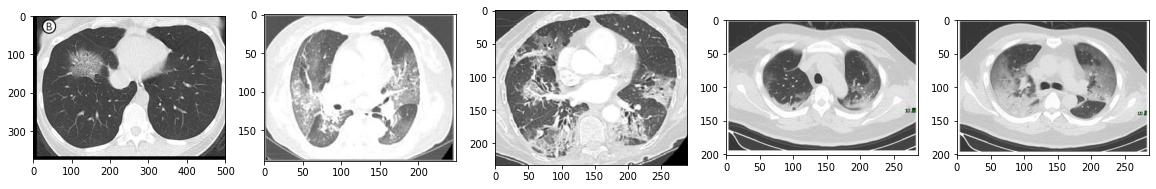

In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms as transforms
import os
import cv2
import random
import matplotlib.pyplot as plt
import torch.optim as optim
from PIL import Image
from torch.utils.tensorboard import SummaryWriter
import glob
import shutil
import numpy as np
from ct_loader import CovidCTDataset

random.seed(0)

log_dir = "~/logs"
writer = SummaryWriter(log_dir)
PATH = '/content/COVID-CT/'
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")



def imshow(img):
    # img = img / 5 + 1     # unnormalize

    plt.figure(figsize=(20, 10))
    columns = 5
    for i, image in enumerate(img):
        plt.subplot(int(len(img) / columns) + 1, columns, i + 1)
        plt.imshow(image[0])
    for i in img:
        npimg = i.numpy()
        plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


covid_files_path = PATH + "CT_COVID"
nocov_files_path = PATH + "CT_NonCOVID"
covid_files = [os.path.join(covid_files_path, x) for x in os.listdir(covid_files_path)]
covid_images = [cv2.imread(x) for x in random.sample(covid_files, 5)]

plt.figure(figsize=(20, 10))
columns = 5
for i, image in enumerate(covid_images):
    plt.subplot(int(len(covid_images) / columns) + 1, columns, i + 1)
    plt.imshow(image)
plt.show()

normalize = transforms.Normalize(mean=[0,0,0], std=[1,1,1])
train_transformer = transforms.Compose([
    transforms.Resize(256),
    transforms.RandomResizedCrop(224, scale=(0.5, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    normalize
])
val_transformer = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    normalize
    
])

batchsize =4
num_clients = 8
# num_selected = 8
num_rounds = 3
epochs = 2
batch_size = 16

traindata = CovidCTDataset(root_dir=PATH,
                          classes=['CT_NonCOVID', 'CT_COVID'],
                          covid_files=PATH + 'Data-split/COVID/trainCT_COVID2.txt',
                          non_covid_files=PATH + 'Data-split/NonCOVID/trainCT_NonCOVID2.txt',
                          transform=train_transformer)
valdata = CovidCTDataset(root_dir=PATH,
                        classes=['CT_NonCOVID', 'CT_COVID'],
                        covid_files=PATH + 'Data-split/COVID/valCT_COVID.txt',
                        non_covid_files=PATH + 'Data-split/NonCOVID/valCT_NonCOVID.txt',
                        transform=val_transformer)
testdata = CovidCTDataset(root_dir=PATH,
                          classes=['CT_NonCOVID', 'CT_COVID'],
                          covid_files=PATH + 'Data-split/COVID/testCT_COVID2.txt',
                          non_covid_files=PATH + 'Data-split/NonCOVID/testCT_NonCOVID2.txt',
                          transform=val_transformer)

from PIL import Image
import matplotlib.pyplot as plt


qouta=[int(len(traindata) / num_clients) for _ in range(num_clients)]
qouta[-1]=qouta[-1]+(len(traindata)-sum(qouta))
traindata_split = torch.utils.data.random_split(traindata, [x for x in qouta])
train_loader = [torch.utils.data.DataLoader(x, batch_size=batch_size, shuffle=True) for x in traindata_split]
 


test_loader = torch.utils.data.DataLoader(testdata, batch_size=len(testdata), drop_last=False, shuffle=False)


# Creating decentralized datasets



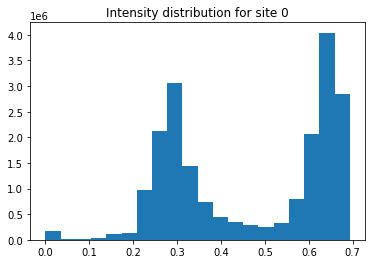

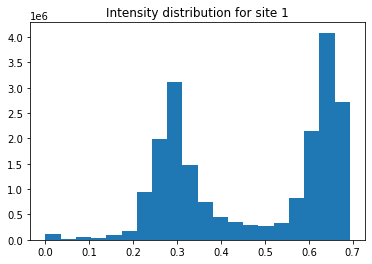

KeyboardInterrupt: ignored

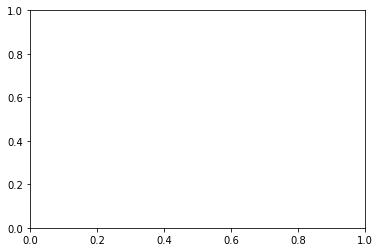

In [ ]:


for siteidx,data in enumerate( traindata_split):
    datahist=[]
    for  idx in range (data.__len__()):
         datahist.append(data.__getitem__(idx)['img'][0].numpy().flatten())
    datahist=np.reshape(datahist,(-1,1))
    # print(np.shape(datahist))
    plt.hist(np.log(datahist+1),bins=20)
    plt.title('Intensity distribution for site '+str(siteidx))
    plt.show()

In [ ]:
print(valdata.__len__())
print(traindata.__len__())
print(testdata.__len__())

118
3227
503


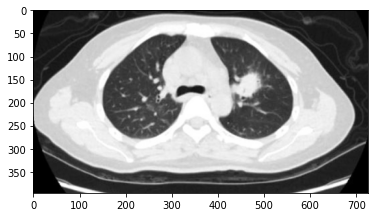

In [ ]:
image=plt.imread('/content/COVID-CT/CT_COVID/Talaromyces-marneffei-infection-relapse-presenting-as-ost_2020_International-p1-12%1.png')
plt.imshow(image)
plt.show()

In [ ]:
print(image.shape)

(396, 726, 4)


['Site 0', 'Site 1', 'Site 2', 'Site 3', 'Site 4', 'Site 5', 'Site 6', 'Site 7']
[200, 209, 202, 204, 185, 213, 181, 207]
[203, 194, 201, 199, 218, 190, 222, 199]


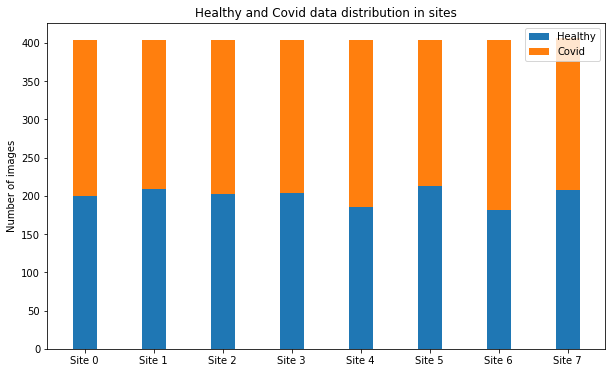

In [ ]:
siteids=[]
siteones=[]
sitezeros=[]
for siteidx,data in enumerate( traindata_split):
    siteids.append("Site "+str(siteidx))
    datalabels=[]
    for  idx in range (data.__len__()):
         datalabels.append(data.__getitem__(idx)['label'])
    siteones.append(datalabels.count(1))
    sitezeros.append(datalabels.count(0))
print(siteids)
print(siteones)
print(sitezeros)

    # datahist=np.reshape(datahist,(-1,1))
    # # print(np.shape(datahist))
    # plt.hist(np.log(datahist+1),bins=20)
    # plt.title('Intensity distribution for site '+str(siteidx))
    # plt.show()


fig, ax = plt.subplots(figsize=(10,6))
width = 0.35       # the width of the bars: can also be len(x) sequence

ax.bar(siteids, siteones, width,  label='Healthy')
ax.bar(siteids, sitezeros, width,  bottom=siteones,
       label='Covid')

ax.set_ylabel('Number of images')
ax.set_title('Healthy and Covid data distribution in sites')
ax.legend()

plt.show()

In [ ]:
# import torchvision.models as models
# resnet18 = ResNet(layers=101,pretrained=True)

# global_model = resnet18.cuda()
# # client_models = [resnet18.cuda() for _ in range(num_selected)]




# Runnining FL



import torchvision.models as models
from torchsummary import summary as summary2
# num_rounds=100
num_rounds=2
modelslist=['ResNet101']
patience_epoch=1000
numclientlist=[4,10,20]
epochslist=[80]
batchsize =4
# num_selected = 8
epochs = 2
batch_size = 16

import os
for network in modelslist:
  for num_clients in numclientlist:
      num_selected=num_clients

      traindata = CovidCTDataset(root_dir=PATH,
                                classes=['CT_NonCOVID', 'CT_COVID'],
                                covid_files=PATH + 'Data-split/COVID/trainCT_COVID2.txt',
                                non_covid_files=PATH + 'Data-split/NonCOVID/trainCT_NonCOVID2.txt',
                                transform=train_transformer)
      valdata = CovidCTDataset(root_dir=PATH,
                              classes=['CT_NonCOVID', 'CT_COVID'],
                              covid_files=PATH + 'Data-split/COVID/valCT_COVID.txt',
                              non_covid_files=PATH + 'Data-split/NonCOVID/valCT_NonCOVID.txt',
                              transform=val_transformer)
      testdata = CovidCTDataset(root_dir=PATH,
                                classes=['CT_NonCOVID', 'CT_COVID'],
                                covid_files=PATH + 'Data-split/COVID/testCT_COVID2.txt',
                                non_covid_files=PATH + 'Data-split/NonCOVID/testCT_NonCOVID2.txt',
                                transform=val_transformer)

      qouta=[int(len(traindata) / num_clients) for _ in range(num_clients)]
      qouta[-1]=qouta[-1]+(len(traindata)-sum(qouta))
      traindata_split = torch.utils.data.random_split(traindata, [x for x in qouta])
      train_loader = [torch.utils.data.DataLoader(x, batch_size=batch_size, shuffle=True) for x in traindata_split]
      


      test_loader = torch.utils.data.DataLoader(testdata, batch_size=len(testdata), drop_last=False, shuffle=False)

      val_loader = torch.utils.data.DataLoader(valdata, batch_size=batch_size, drop_last=False, shuffle=False)



      for epochs in epochslist:
          filename=str(num_clients)+str(num_rounds)+str(epochs)+str(network)
          print(filename)
          for items in os.listdir('/content/drive/MyDrive/PhD/federated-learning/'):
              if filename in items:
                  break
          if network=='ResNet101':
            print('Network is'+network)
            global_model=ResNet().cuda()

            # global_model =  models.resnet101(pretrained=False).cuda()
            # client_models = [models.resnet101(pretrained=False).cuda() for _ in range(num_selected)]

            # global_model.fc = nn.Linear(2048, 2,device='cuda:0')

            # for client_model in client_models:
            #          client_model.fc = nn.Linear(2048, 2,device='cuda:0')

          if network=='Mobilenet_v3':
            print('Network is'+network)

            
            global_model =  models.mobilenet_v3_large(pretrained=True).cuda()
            global_model.classifier[3]=nn.Linear(1280,2).cuda()

          
          if network=='Densenet':
            print('Network is'+network)

            
            global_model = models.densenet121(pretrained=True).cuda()
            global_model.classifier=nn.Linear(1280,2).cuda()
        
          if network=='Squeezenet':
            print('Network is'+network)

            
            global_model = models.SqueezeNet().cuda()

            global_model.classifier[1]=nn.Conv2d(512,2,kernel_size=(1,1),stride=(1,1)).cuda()
    
          thisdict={}
          num_selected=num_clients

          thisdict['args']={}
          thisdict['args']['num_rounds']= num_rounds
          thisdict['args']['num_clients']= num_clients
          thisdict['args']['num_selected']= num_selected
          thisdict['args']['epochs per round']= epochs
          thisdict['args']['batch_size']= batch_size






          thisdict['results']={}


          import time

          t0 = time.time()


          from PIL import Image

          # select random clients
          client_idx = np.random.permutation(num_clients)[:num_selected]
          opt = optim.SGD(global_model.parameters(), lr=0.05) 

          # client update
          loss = 0
          for round in range(num_rounds):
              thisdict['results'][str(round)]={}

              for client_number in range(num_selected):      

                      i=client_number
                      loss += client_update(global_model, opt, train_loader[client_idx[i]], client_number,epoch=epochs,patience_epoch=patience_epoch)
                      TP,FP,TN,FN,precision,recall,F1,test_loss, acc = test(global_model, test_loader)
                      thisdict['results'][str(round)][str(i)]={}
                      thisdict['results'][str(round)][str(i)]['TP']=TP
                      thisdict['results'][str(round)][str(i)]['FP']=FP
                      thisdict['results'][str(round)][str(i)]['TN']=TN
                      thisdict['results'][str(round)][str(i)]['FN']=FN
                      thisdict['results'][str(round)][str(i)]['precision']=precision
                      thisdict['results'][str(round)][str(i)]['recall']=recall
                      thisdict['results'][str(round)][str(i)]['F1']=F1
                      thisdict['results'][str(round)][str(i)]['test_loss']=test_loss
                      thisdict['results'][str(round)][str(i)]['acc']=acc
                      thisdict['results'][str(round)][str(i)]['train loss']=loss / num_selected

                      print('average train loss %0.3g | test loss %0.3g | test acc: %0.3f' % (loss / num_selected, test_loss, acc))
                      print(thisdict)

          t1 = time.time()

          total = t1-t0
          thisdict['args']['time']=total
          print('Total passed time was:',total)
          path='/content/drive/MyDrive/PhD/federated-learning/'
          filename='cwt'+str(network)+str(num_clients)+str(epochs)+str(num_rounds)
          import json
          with open(path+filename+'.json', 'w') as fp:
              json.dump(thisdict, fp)
# # serer aggregate
# server_aggregate(global_model, client_models)
# test_loss, acc = test(global_model, test_loader)

# print('average train loss %0.3g | test loss %0.3g | test acc: %0.3f' % (loss / num_selected, test_loss, acc))

4280ResNet101
Network isResNet101


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth



************* Started training Client number: 0 ***************
Epoch:0


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Training loss 2.58 |
Epoch:1
Training loss 1.2 |
Epoch:2
Training loss 1.28 |
Epoch:3
Training loss 1.15 |
Epoch:4
Training loss 0.967 |
Epoch:5
Training loss 0.925 |
Epoch:6
Training loss 1.01 |
Epoch:7
Training loss 0.752 |
Epoch:8
Training loss 0.489 |
Epoch:9
Training loss 0.499 |
Epoch:10
Training loss 0.746 |
Epoch:11
Training loss 0.467 |
Epoch:12
Training loss 0.515 |
Epoch:13
Training loss 0.537 |
Epoch:14
Training loss 0.356 |
Epoch:15
Training loss 0.32 |
Epoch:16
Training loss 0.325 |
Epoch:17
Training loss 0.467 |
Epoch:18
Training loss 0.359 |
Epoch:19
Training loss 0.31 |
Epoch:20
Training loss 0.614 |
Epoch:21
Training loss 0.391 |
Epoch:22
Training loss 0.258 |
Epoch:23
Training loss 0.258 |
Epoch:24
Training loss 0.277 |
Epoch:25
Training loss 0.25 |
Epoch:26
Training loss 0.25 |
Epoch:27
Training loss 0.26 |
Epoch:28
Training loss 0.313 |
Epoch:29
Training loss 0.219 |
Epoch:30
Training loss 0.148 |
Epoch:31
Training loss 0.346 |
Epoch:32
Training loss 0.304 |
Epoch:

In [ ]:
!cp -r /content/COVID-CT '/content/drive/MyDrive/PhD'

In [ ]:
sum([int(len(traindata) / num_clients) for _ in range(num_clients)])

424